## Imports

In [1]:
import bilby
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd
import seaborn as sns
import corner
import glob

from astropy import cosmology, units
from astropy.cosmology import Planck15
from scipy.interpolate import interp1d

from bilby.core.prior import Uniform, LogUniform, PriorDict, Constraint
from bilby.gw.prior import BBHPriorDict
import gwpopulation as gwpop
import gwpopulation_pipe
from gwpopulation.models import mass, spin
from gwpopulation.conversions import convert_to_beta_parameters

xp = gwpop.cupy_utils.xp

### Posteriors

In [2]:
luminosity_distances = np.linspace(1, 10000, 1000)
redshifts = np.array([cosmology.z_at_value(cosmology.Planck15.luminosity_distance, 
                                                   dl * units.Mpc) for dl in luminosity_distances])
dl_to_z = interp1d(luminosity_distances, redshifts)

#### GWTC-1

In [3]:
parameter_translator = dict(
    mass_1_det = 'm1_detector_frame_Msun',
    mass_2_det = 'm2_detector_frame_Msun',
    luminosity_distance = 'luminosity_distance_Mpc',
    a_1 = 'spin1',
    a_2 = 'spin2',
    cos_tilt_1 = 'costilt1',
    cos_tilt_2 = 'costilt2')

posteriors = list()
i = 0

file = '../../GWTC-1/GWTC-1_sample_release/GW{}_GWTC-1.hdf5'

events = ['150914', '151012', '151226', '170104', '170608', 
          '170729', '170809', '170814', '170818', '170823']

for event in events:
    print(i, event)
    i = i+1
    _posterior = pd.DataFrame()
    with h5py.File(file.format(event), 'r') as ff:
        for my_key, gwtc_key in parameter_translator.items():
            _posterior[my_key] = ff['Overall_posterior'][gwtc_key]
    posteriors.append(_posterior)
    
for posterior in posteriors:
    posterior['redshift'] = dl_to_z(posterior['luminosity_distance'])
    posterior['mass_1'] = posterior['mass_1_det'] / (1 + posterior['redshift'])
    posterior['mass_2'] = posterior['mass_2_det'] / (1 + posterior['redshift'])
    posterior['mass_ratio'] = posterior['mass_2'] / posterior['mass_1']
    del posterior["mass_1_det"]
    del posterior["mass_2_det"]

0 150914
1 151012
2 151226
3 170104
4 170608
5 170729
6 170809
7 170814
8 170818
9 170823


#### GWTC-2

In [4]:
parameter_translator = dict(
    mass_1 = 'mass_1_source',
    mass_2 = 'mass_2_source',
    mass_ratio = 'mass_ratio',
    luminosity_distance = 'luminosity_distance',
    a_1 = 'a_1',
    a_2 = 'a_2',
    cos_tilt_1 = 'cos_tilt_1',
    cos_tilt_2 = 'cos_tilt_2',
    redshift = 'redshift')

# 44 events excluding
# S190425z.h5
# S190426c.h5
# S190719an.h5
# S190814bv.h5
# S190909w.h5

events = ['S190408an.h5', 'S190412m.h5', 'S190413ac.h5', 
          'S190413i.h5', 'S190421ar.h5', 'S190424ao.h5', 
          'S190503bf.h5', 'S190512at.h5', 'S190513bm.h5',
          'S190514n.h5', 'S190517h.h5', 'S190519bj.h5',
          'S190521g.h5', 'S190521r.h5', 'S190527w.h5',
          'S190602aq.h5', 'S190620e.h5', 'S190630ag.h5',
          'S190701ah.h5', 'S190706ai.h5', 'S190707q.h5',
          'S190708ap.h5', 'S190720a.h5', 'S190727h.h5',
          'S190728q.h5', 'S190731aa.h5', 'S190803e.h5',
          'S190828j.h5', 'S190828l.h5', 'S190910s.h5', 
          'S190915ak.h5', 'S190924h.h5', 'S190929d.h5',
          'S190930s.h5']

file = '../../GWTC-2/GWTC-2_sample_release/{}'

for event in events:
    print(i, event)
    i = i+1
    _posterior = pd.DataFrame()
    with h5py.File(file.format(event), 'r') as ff:
        for my_key, gwtc_key in parameter_translator.items():
            _posterior[my_key] = ff["PrecessingSpinIMRHM"]['posterior_samples'][gwtc_key]
    posteriors.append(_posterior)

10 S190408an.h5
11 S190412m.h5
12 S190413ac.h5
13 S190413i.h5
14 S190421ar.h5
15 S190424ao.h5
16 S190503bf.h5
17 S190512at.h5
18 S190513bm.h5
19 S190514n.h5
20 S190517h.h5
21 S190519bj.h5
22 S190521g.h5
23 S190521r.h5
24 S190527w.h5
25 S190602aq.h5
26 S190620e.h5
27 S190630ag.h5
28 S190701ah.h5
29 S190706ai.h5
30 S190707q.h5
31 S190708ap.h5
32 S190720a.h5
33 S190727h.h5
34 S190728q.h5
35 S190731aa.h5
36 S190803e.h5
37 S190828j.h5
38 S190828l.h5
39 S190910s.h5
40 S190915ak.h5
41 S190924h.h5
42 S190929d.h5
43 S190930s.h5


In [5]:
BOUNDS = dict(
    mass_1=(2, 100),
    mass_ratio=(0, 1),
    a_1=(0, 1),
    a_2=(0, 1),
    cos_tilt_1=(-1, 1),
    cos_tilt_2=(-1, 1),
    redshift=(0, 2.3))
PRIOR_VOLUME = (
    (BOUNDS["mass_1"][1] - BOUNDS["mass_1"][0]) ** 2
    * (BOUNDS["a_1"][1] - BOUNDS["a_1"][0])
    * (BOUNDS["a_2"][1] - BOUNDS["a_2"][0])
    * (BOUNDS["cos_tilt_1"][1] - BOUNDS["cos_tilt_1"][0]))

In [6]:
for posterior in posteriors:
    posterior["prior"] = 1 / PRIOR_VOLUME

### Calculation

In [7]:
modelA = bilby.hyper.model.Model([mass.SinglePeakSmoothedMassDistribution(),
                                  spin.iid_spin])

### Selection Effects

In [8]:
# Check the structure of VT file

vt_file = '../Sensitivity/O3aSensitivity/o3a_bbhpop_inj_info.hdf'

ff = h5py.File(vt_file, 'r')
print(list(ff.keys()))
print(list(ff['injections'].keys()))
print(list(ff.attrs.items()))

['injections']
['distance', 'gps_time_int', 'ifar_gstlal', 'ifar_pycbc_bbh', 'ifar_pycbc_full', 'mass1_source', 'mass2_source', 'optimal_snr_h', 'optimal_snr_l', 'redshift', 'sampling_pdf', 'spin1z', 'spin2z']
[('N_exp/R(z=0)', 979.0426119706958), ('analysis_time_s', 15843600), ('max_redshift', 2.3), ('n_accepted', 156878), ('n_rejected', 76825621), ('surveyed_VT_Gpc_yr', 167.60465680916), ('total_generated', 76982499)]


In [9]:
# VT Function

from bilby.core.utils import logger
from gwpopulation import vt
from gwpopulation.cupy_utils import xp
from bilby.hyper.model import Model

def _load_pycbc_injection_data(vt_file, ifar_threshold, vt_name="N_exp/R(z=0)"):
    logger.info(f"Loading VT data from {vt_file}.")
    f = h5py.File(vt_file, 'r')
    
    Tobs = f.attrs['analysis_time_s']/(365.25*24*3600) # years
    Ndraw = f.attrs['total_generated']
    m1 = xp.array(f['injections/mass1_source'])
    m2 = xp.array(f['injections/mass2_source'])
    z = xp.array(f['injections/redshift'])
    s1z = xp.array(f['injections/spin1z'])
    s2z = xp.array(f['injections/spin2z'])
    p_draw = xp.array(f['injections/sampling_pdf'])
    gstlal_ifar = xp.array(f['injections/ifar_gstlal'])
    pycbc_ifar = xp.array(f['injections/ifar_pycbc_full'])
    pycbc_bbh_ifar = xp.array(f['injections/ifar_pycbc_bbh'])
    
    found = ((pycbc_bbh_ifar > ifar_threshold) | (pycbc_ifar > ifar_threshold) | (gstlal_ifar > ifar_threshold))
    gwpop_data = dict(
        mass_1 = xp.asarray(m1[found]),
        mass_ratio = xp.asarray(m2[found] / m1[found]),
        redshift = xp.asarray(z[found]),
        prior = xp.asarray(p_draw[found]),
        n_found = xp.sum(found),
        total_generated = Ndraw,
        analysis_time = Tobs)
    return gwpop_data

def injection_resampling_vt(vt_file, model, ifar_threshold = 1, n_events = 44):
    data = _load_pycbc_injection_data(vt_file = vt_file, ifar_threshold = ifar_threshold)
    data["prior"] = data["mass_1"] ** (-2.35 + 1) * data["mass_ratio"] ** 2

    return vt.ResamplingVT(model = model, data = data, n_events = 44)

def load_vt():
    vt_file = '../Sensitivity/O3aSensitivity/o3a_bbhpop_inj_info.hdf'
    vt_model = Model([mass.SinglePeakSmoothedMassDistribution()])
    vt_func = injection_resampling_vt
    
    return vt_func(vt_file, model = vt_model)

selection_function = load_vt()

00:54 bilby INFO    : Loading VT data from ../Sensitivity/O3aSensitivity/o3a_bbhpop_inj_info.hdf.


In [10]:
def prior_conversion(parameters):
    
    """Wrapper around conversion for prior constraints"""
    parameters = parameters.copy()
    added_keys = None
    parameters["amax"] = 1
    parameters, added_keys = convert_to_beta_parameters(parameters)
    return parameters, added_keys

In [11]:
priorsA = PriorDict(conversion_function = prior_conversion)

# mass
priorsA["alpha"] = Uniform(minimum=-4., maximum=12., latex_label=r'$\alpha$')
priorsA["beta"] = Uniform(minimum=-4., maximum=12., latex_label=r'$\beta_q$')
priorsA['delta_m'] = Uniform(minimum=0., maximum=10., latex_label=r'$\delta_m$ $[M_\odot]$')
priorsA["mmin"] = Uniform(minimum=2., maximum=10., latex_label=r'$m_\mathrm{min}$ $[M_\odot]$')
priorsA['mmax'] = Uniform(minimum=30., maximum=100., latex_label=r'$m_\mathrm{max}$ $[M_\odot]$')
priorsA['lam'] = Uniform(minimum=0., maximum=1., latex_label=r'$\lambda_\mathrm{peak}$')
priorsA['mpp'] = Uniform(minimum=20., maximum=50., latex_label=r'$\mu_m$ $[M_\odot]$')
priorsA['sigpp'] = Uniform(minimum=0.4, maximum=10., latex_label=r'$\sigma_m$ $[M_\odot]$')

# spin magnitude 
priorsA["mu_chi"] = Uniform(minimum = 0, maximum = 1, latex_label = r'$\mu_\chi$')
priorsA["sigma_chi"] = Uniform(minimum = 0, maximum = 0.25, latex_label = r'$\sigma^2_\chi$')
priorsA["amax"] = 1
priorsA["alpha_chi"] = Constraint(minimum = 1, maximum = 1e5)
priorsA["beta_chi"] = Constraint(minimum = 1, maximum = 1e5)

# spin orientation
priorsA["xi_spin"] = Uniform(minimum = 0, maximum = 1, latex_label=r'$\zeta$')
priorsA["sigma_spin"] = Uniform(minimum = 0.01, maximum = 4, latex_label=r'$\sigma_t$')

In [12]:
likelihoodA = gwpop.hyperpe.HyperparameterLikelihood(posteriors = posteriors, 
                                                     hyper_prior = modelA,
                                                     conversion_function = prior_conversion,
                                                     selection_function = selection_function)

In [13]:
for ii in range(10):
    likelihoodA.parameters.update(priorsA.sample())
    print(likelihoodA.parameters)
    print(likelihoodA.log_likelihood_ratio())

{'alpha': 3.8971615184268273, 'beta': 11.352191028326107, 'delta_m': 7.570926359943106, 'mmin': 8.467882321499225, 'mmax': 77.58821970642664, 'lam': 0.05174884302118343, 'mpp': 40.88524475635966, 'sigpp': 4.324071028177979, 'mu_chi': 0.4859304820791994, 'sigma_chi': 0.0983440062166939, 'amax': 1.0, 'xi_spin': 0.772754339891035, 'sigma_spin': 1.3928602187425883}
-1.7976931348623157e+308
{'alpha': -0.6069351224468651, 'beta': -3.4643325482791454, 'delta_m': 6.495177431747889, 'mmin': 8.730652249016416, 'mmax': 42.06943163256134, 'lam': 0.037072547772979525, 'mpp': 20.457180514133956, 'sigpp': 0.8434945826163048, 'mu_chi': 0.006144638981202211, 'sigma_chi': 0.16645154260135117, 'amax': 1.0, 'xi_spin': 0.850456122719489, 'sigma_spin': 3.227022203133241}
-1.7976931348623157e+308
{'alpha': 4.477538450910544, 'beta': -1.2436299760994505, 'delta_m': 5.734257395217403, 'mmin': 4.547272446099287, 'mmax': 77.01529397943712, 'lam': 0.259865568876129, 'mpp': 23.64063985268298, 'sigpp': 2.1118338257

In [14]:
likelihoodA.parameters.update(priorsA.sample())
likelihoodA.log_likelihood_ratio()

256.10717338120867

In [15]:
resultA = bilby.run_sampler(likelihood = likelihoodA, priors = priorsA, sampler='dynesty', 
                            nlive = 700, label='default_vt_corrected', outdir = 'default_vt_corrected', 
                            clean = True)

00:58 bilby INFO    : Running for label 'default_vt_corrected', output will be saved to 'default_vt_corrected'
00:58 bilby INFO    : Search parameters:
00:58 bilby INFO    :   alpha = Uniform(minimum=-4.0, maximum=12.0, name=None, latex_label='$\\\\alpha$', unit=None, boundary=None)
00:58 bilby INFO    :   beta = Uniform(minimum=-4.0, maximum=12.0, name=None, latex_label='$\\\\beta_q$', unit=None, boundary=None)
00:58 bilby INFO    :   delta_m = Uniform(minimum=0.0, maximum=10.0, name=None, latex_label='$\\delta_m$ $[M_\\odot]$', unit=None, boundary=None)
00:58 bilby INFO    :   mmin = Uniform(minimum=2.0, maximum=10.0, name=None, latex_label='$m_\\mathrm{min}$ $[M_\\odot]$', unit=None, boundary=None)
00:58 bilby INFO    :   mmax = Uniform(minimum=30.0, maximum=100.0, name=None, latex_label='$m_\\mathrm{max}$ $[M_\\odot]$', unit=None, boundary=None)
00:58 bilby INFO    :   lam = Uniform(minimum=0.0, maximum=1.0, name=None, latex_label='$\\lambda_\\mathrm{peak}$', unit=None, boundary=No

0it [00:00, ?it/s]

00:58 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 700, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 420, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7f10c8ee2a00>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
00:58 bilby INFO    : Checkpoint every check_point_delta_t = 600s
00:58 bilby INFO    : Using dynesty version 1.0.1
00:58 bilby INFO    : Using the bilby-implemented rwalk samp

06:15 bilby INFO    : Sampling time: 1 day, 5:13:38.419192
06:15 bilby INFO    : Summary of results:
nsamples: 14734
ln_noise_evidence:    nan
ln_evidence:    nan +/-  0.197
ln_bayes_factor: 484.645 +/-  0.197



In [17]:
from matplotlib import rcParams
rcParams["text.usetex"] = True
rcParams["font.serif"] = "Computer Modern"
rcParams["font.family"] = "Serif"
rcParams["xtick.labelsize"]=14
rcParams["ytick.labelsize"]=14
rcParams["xtick.direction"]="in"
rcParams["ytick.direction"]="in"
rcParams["legend.fontsize"]=15
rcParams["axes.labelsize"]=16
rcParams["axes.grid"] = True
rcParams["grid.color"] = 'black'
rcParams["grid.linewidth"] = 1.
rcParams["grid.alpha"] = 0.6

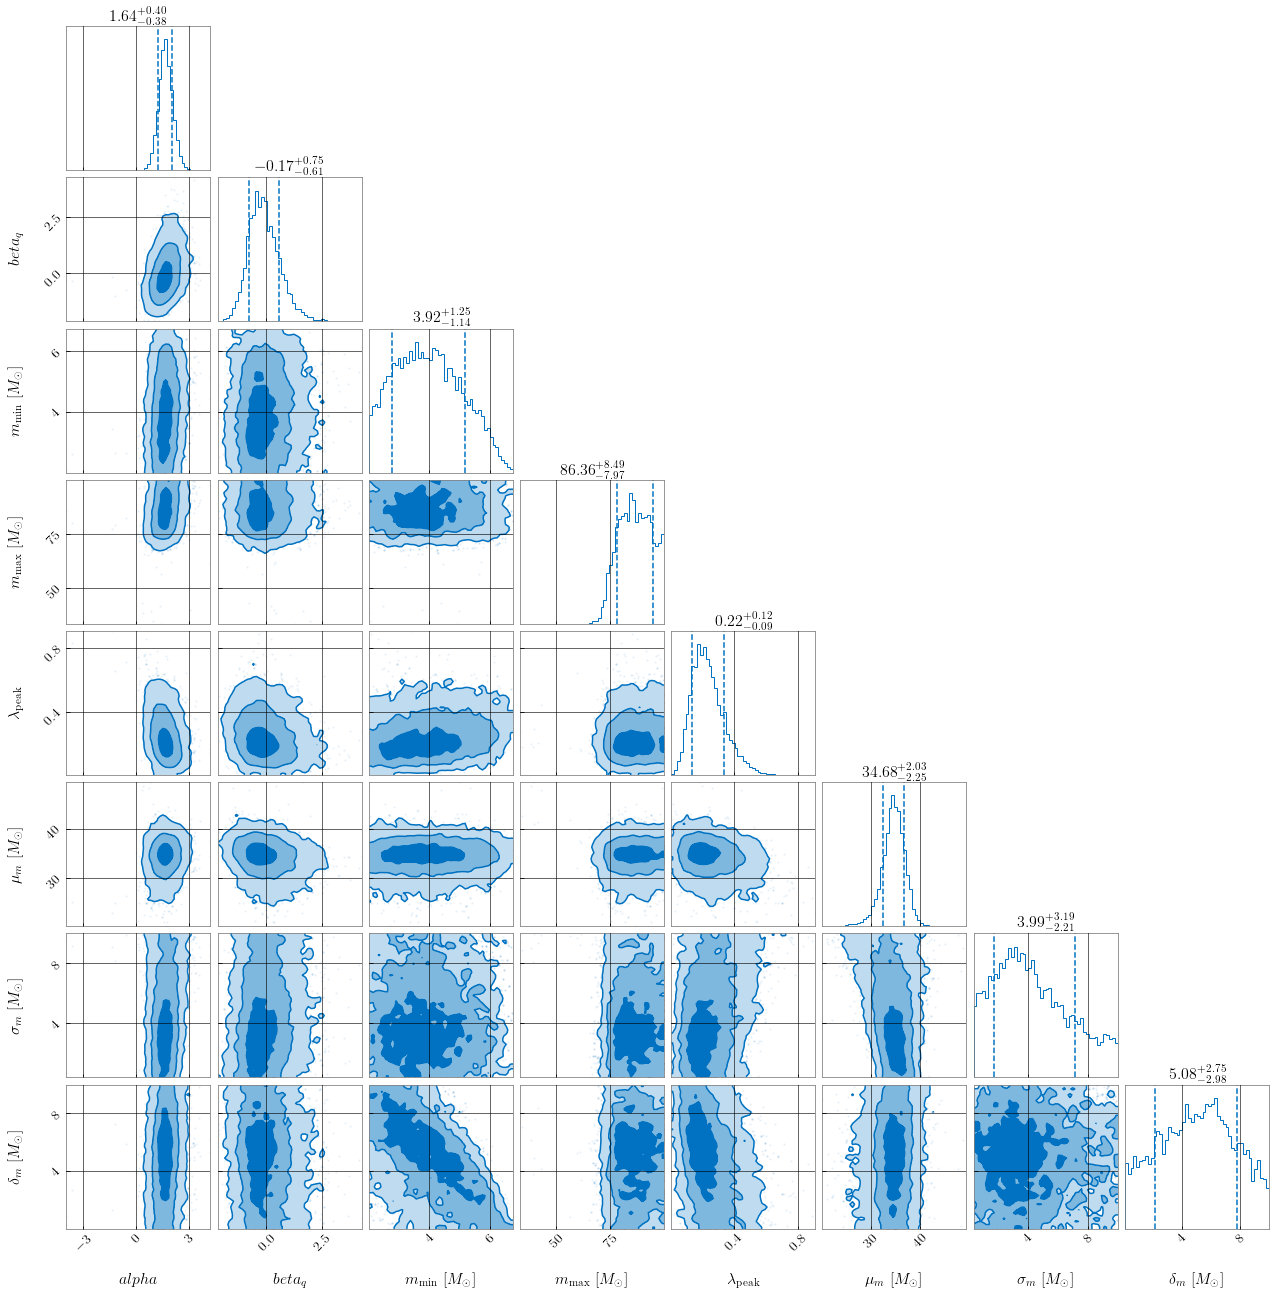

In [18]:
resultA.plot_corner(parameters = ('alpha', 'beta', 'mmin', 'mmax', 'lam', 'mpp', 'sigpp', 'delta_m'))

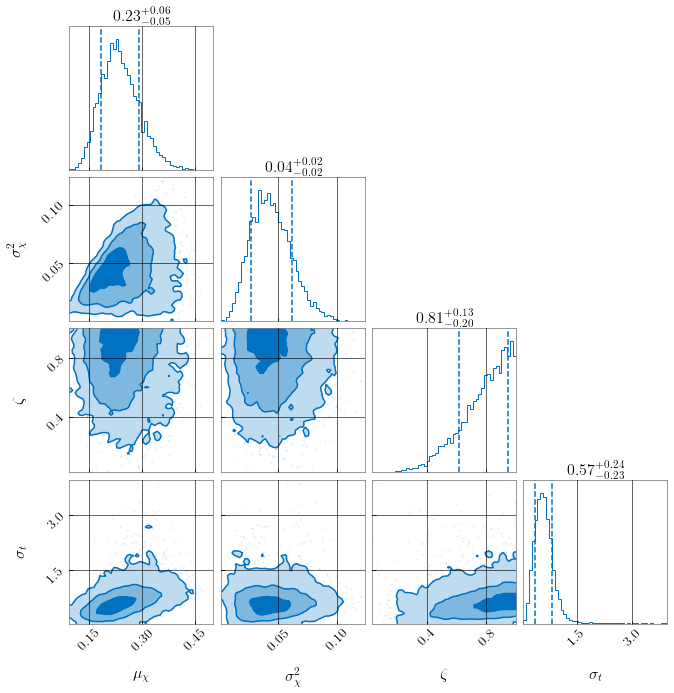

In [19]:
resultA.plot_corner(parameters = ('mu_chi', 'sigma_chi', 'xi_spin', 'sigma_spin'))

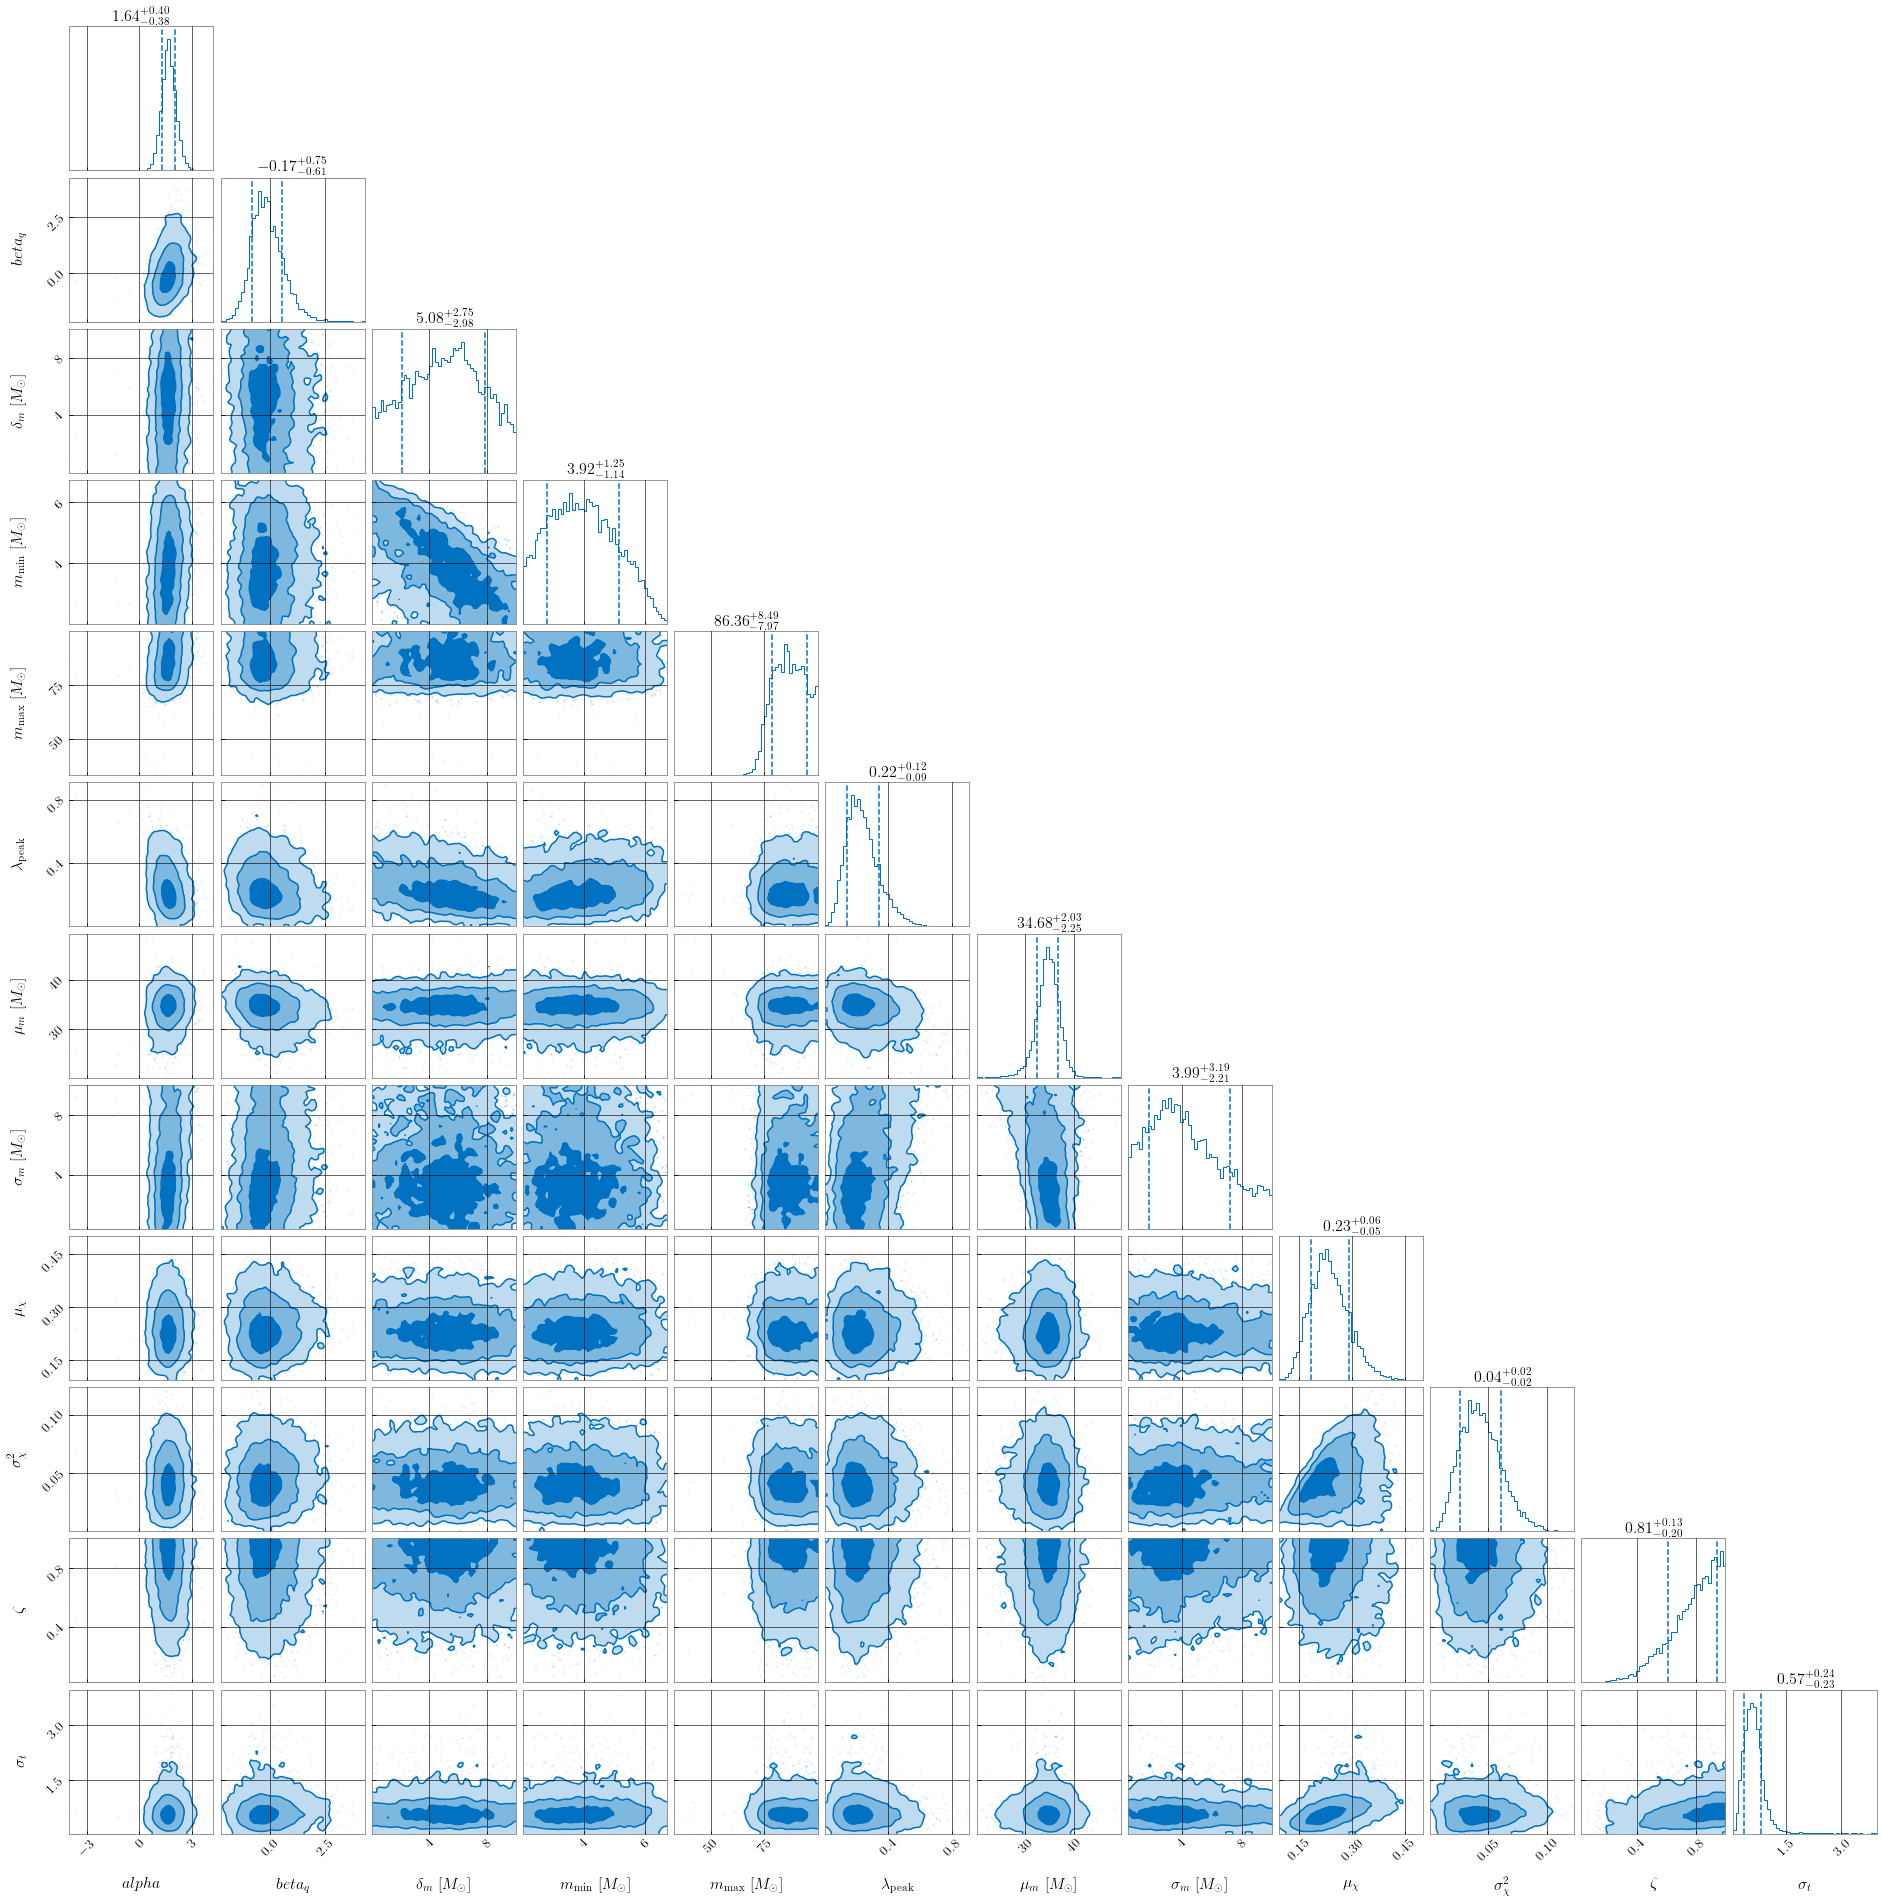

In [20]:
resultA.plot_corner()